In [3]:
# Cell 1: Set up GPU, inspect the file format, and initialize the graph
import torch
import safetensors
from safetensors import safe_open
import networkx as nx
import numpy as np

# Set the GPU device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the file
file_path = "/data/scratch/kaivuh/kronfluencer/influence_results/tinystories/scores_tinystories_scores/pairwise_scores.safetensors"
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    # Print the keys (tensor names) in the file
    print("Tensor keys:", f.keys())
    
    # Load and print information about the first tensor
    first_key = list(f.keys())[0]
    first_tensor = f.get_tensor(first_key)
    print(f"\nFirst tensor '{first_key}':")
    print("Shape:", first_tensor.shape)
    print("Data type:", first_tensor.dtype)
    print("Device:", first_tensor.device)
    print("First few values:", first_tensor.flatten()[:5])

    # Initialize the graph
    G = nx.Graph()
    
    # Add nodes to the graph
    num_query_nodes = first_tensor.shape[0]
    num_key_nodes = first_tensor.shape[1]
    
    G.add_nodes_from(range(num_query_nodes), bipartite=0)  # Query nodes
    G.add_nodes_from(range(num_query_nodes, num_query_nodes + num_key_nodes), bipartite=1)  # Key nodes
    
    # Add edges to the graph
    for i in range(num_query_nodes):
        for j in range(num_key_nodes):
            weight = first_tensor[i, j].item()
            if weight != 0:
                G.add_edge(i, j + num_query_nodes, weight=weight)

print(f"\nGraph initialized with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Using device: cuda:2
Tensor keys: ['all_modules']

First tensor 'all_modules':
Shape: torch.Size([100, 1000])
Data type: torch.bfloat16
Device: cuda:2
First few values: tensor([ 1.3107e+05,  1.2560e+03,  2.7200e+03, -2.1600e+02,  1.1950e+02],
       device='cuda:2', dtype=torch.bfloat16)

Graph initialized with 1100 nodes and 99987 edges


In [14]:
# Cell 2: Analyze influence scores for selected eval examples

import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer

from pipeline import MODEL_NAME, get_tinystories_dataset
from kronfluence.analyzer import Analyzer

def analyze_selected_examples():
    # Load scores
    scores = Analyzer.load_file("/data/scratch/kaivuh/kronfluencer/influence_results/tinystories/scores_tinystories_scores/pairwise_scores.safetensors")[
        "all_modules"
    ].float()
    
    train_dataset = get_tinystories_dataset()
    eval_dataset = get_tinystories_dataset()
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)

    # Select 5 random eval examples
    selected_eval_indices = torch.randint(0, 100, (5,)).tolist()

    for eval_idx in selected_eval_indices:
        print(f"\nEval example {eval_idx}:")
        print(tokenizer.decode(eval_dataset[eval_idx]["input_ids"]))
        
        # Get top influential train examples, ignoring the same index
        scores_for_eval = scores[eval_idx].clone()
        scores_for_eval[eval_idx] = float('-inf')  # Ensure this index isn't selected
        top_train_indices = torch.topk(scores_for_eval, k=6).indices.tolist()  # Get 6 to ensure we have at least 5 after filtering
        
        print("\nTop 5 influential train examples:")
        printed_count = 0
        for train_idx in top_train_indices:
            if train_idx != eval_idx and printed_count < 5:
                print(f"\nRank {printed_count+1}, Train example {train_idx}:")
                print(tokenizer.decode(train_dataset[train_idx]["input_ids"]))
                print(f"Influence score: {scores[eval_idx][train_idx].item():.4f}")
                printed_count += 1
            if printed_count == 5:
                break
        
        print("=" * 80)

analyze_selected_examples()

Loaded tokenized dataset from disk.
Loaded tokenized dataset from disk.

Eval example 91:
One day, Mary was sitting on the grass in the park, eating a sandwich. She chewed it slowly, looking around. Suddenly, something sparkly caught her eye - it was a silver necklace glistening in the sun. Mary noticed it was near a bush, so she crawled over to take a closer look. 

When she got close, Mary could see that the necklace was suspended from a thin branch. She reached out to take it in her tiny hand and felt it's cool metal. 

Just then, a voice called out from behind her. It was an old woman. 
 
"Do you like it?" she said.

Mary was a bit anxious but nodded and smiled.

"It's yours," the woman said warmly. "I saw you admiring it and thought you might like to have it."

Mary thanked the woman politely, before heading home with the new silver necklace in her pocket. From that day onward, every time Mary chewed her lunch in the park, she would also play with her silver necklace, and think ba

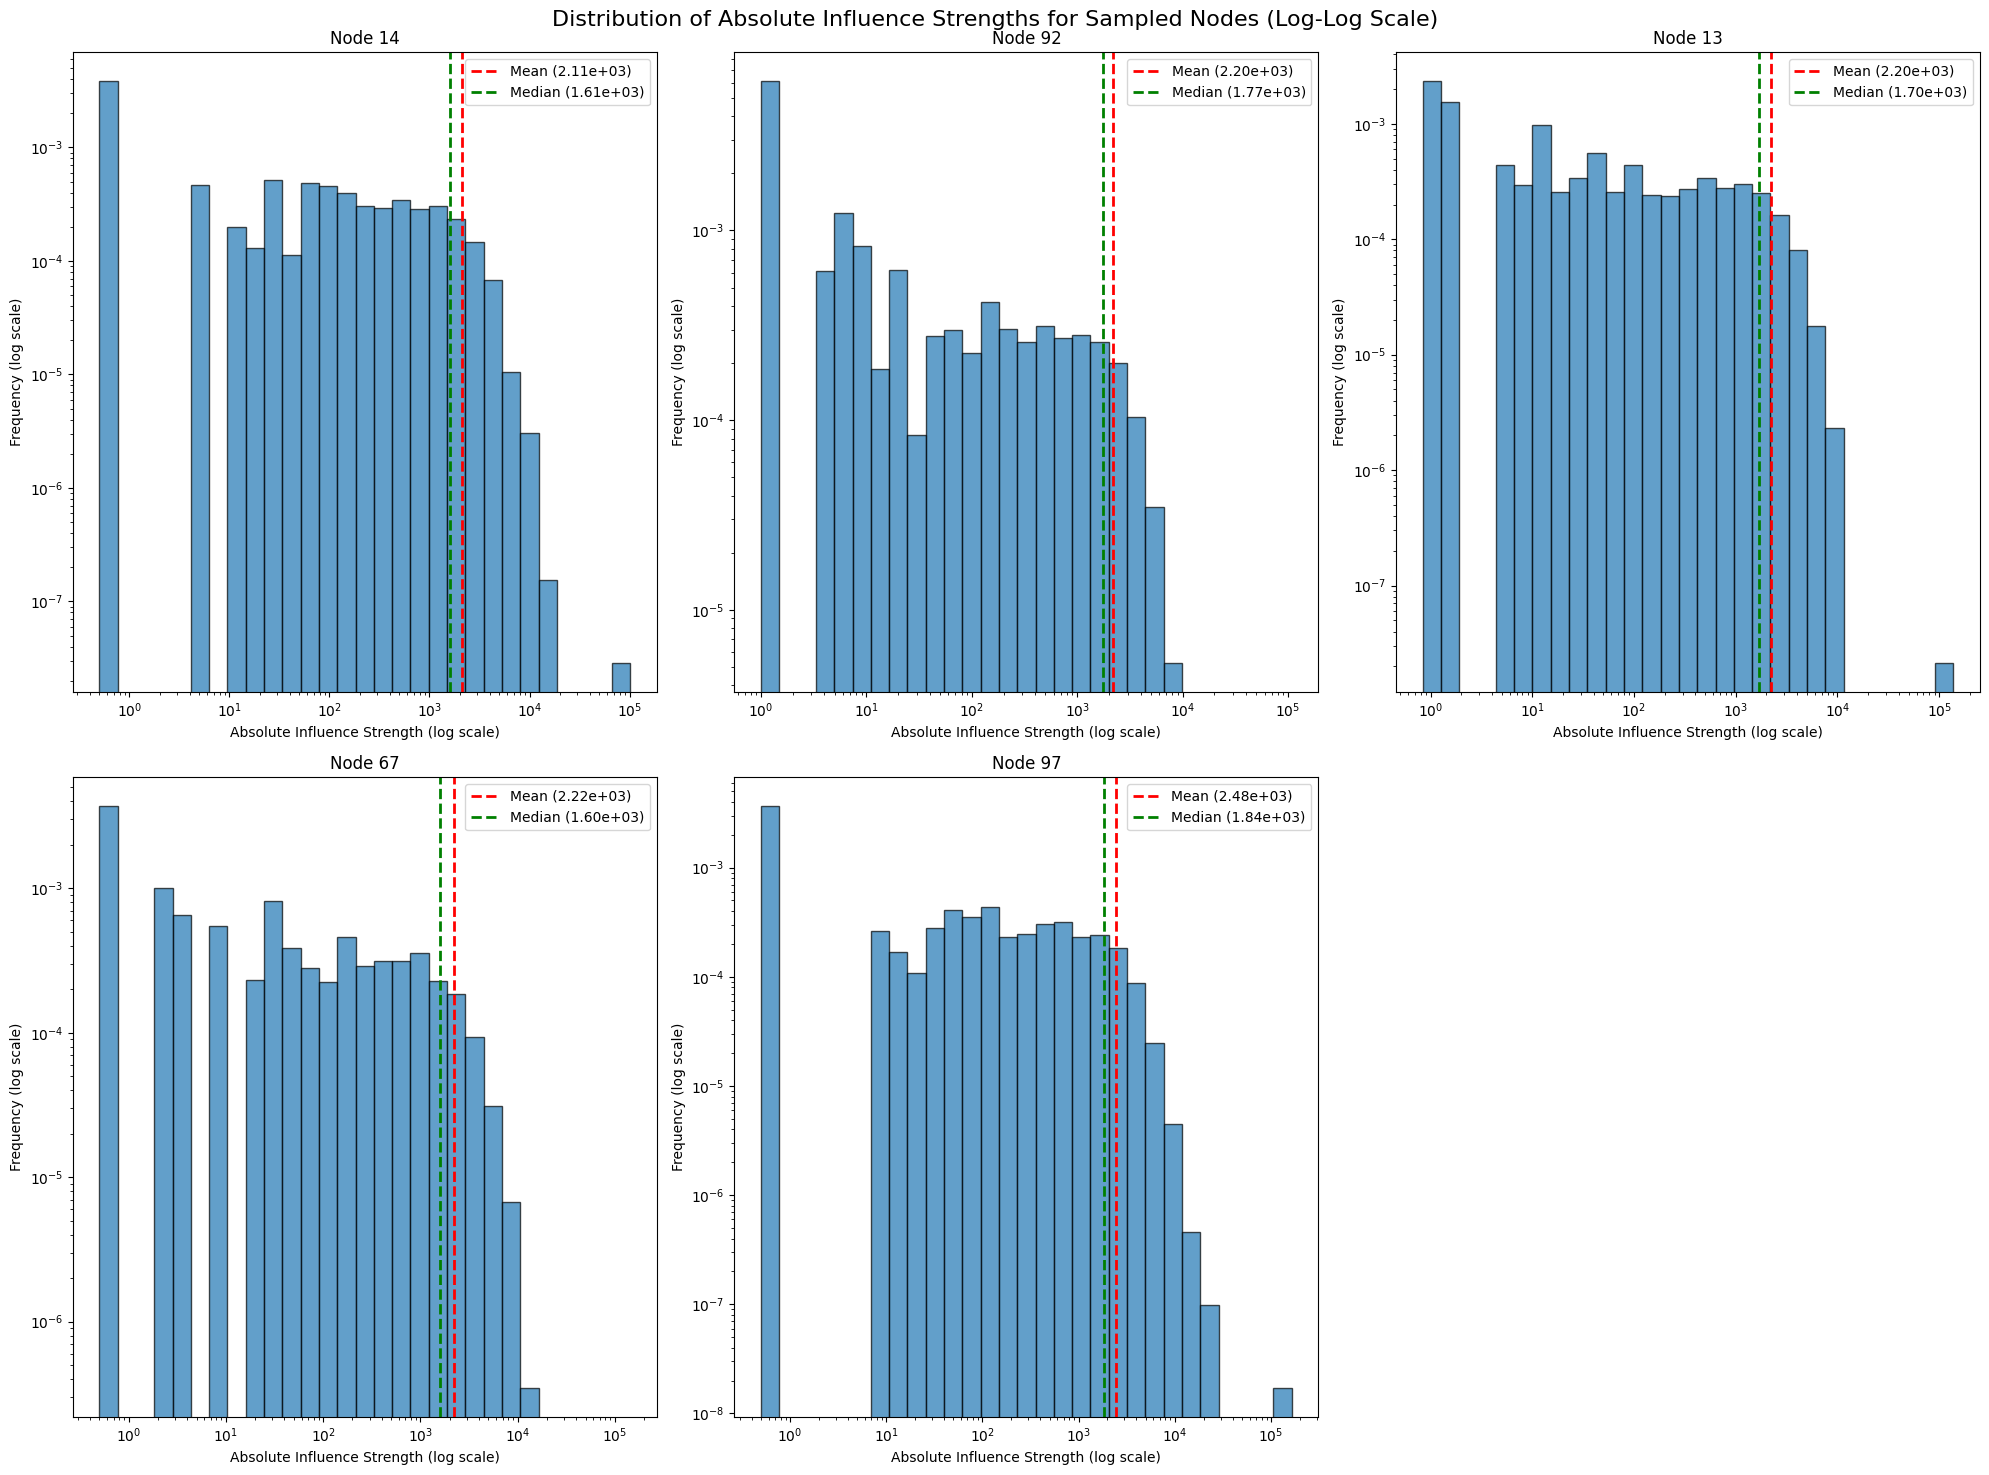


Summary statistics for sampled nodes (absolute values):

Node 14:
  Mean: 2.1120e+03
  Median: 1.6120e+03
  Std Dev: 3.5741e+03
  Min: 5.0000e-01
  Max: 1.0138e+05

Node 92:
  Mean: 2.1952e+03
  Median: 1.7720e+03
  Std Dev: 3.7386e+03
  Min: 1.0000e+00
  Max: 1.0854e+05

Node 13:
  Mean: 2.1992e+03
  Median: 1.7040e+03
  Std Dev: 4.6096e+03
  Min: 8.3594e-01
  Max: 1.3824e+05

Node 67:
  Mean: 2.2237e+03
  Median: 1.5960e+03
  Std Dev: 4.8340e+03
  Min: 5.0000e-01
  Max: 1.4336e+05

Node 97:
  Mean: 2.4793e+03
  Median: 1.8360e+03
  Std Dev: 5.5540e+03
  Min: 5.0000e-01
  Max: 1.6486e+05


In [5]:
# Cell 3: Sample nodes and plot their absolute influence strength distributions on log-log scales
import numpy as np
import matplotlib.pyplot as plt
import random

# Get the query nodes (assuming these are the first 100 nodes)
query_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0][:100]

# Sample 5 random nodes from the query nodes
sampled_nodes = random.sample(query_nodes, 5)

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle("Distribution of Absolute Influence Strengths for Sampled Nodes (Log-Log Scale)", fontsize=16)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot histograms for each sampled node
for i, node in enumerate(sampled_nodes):
    # Get the absolute weights of edges connected to this node
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    
    # Remove zero values (if any) for log scale
    weights = weights[weights > 0]
    
    # Plot histogram on log-log scale
    counts, bins, _ = axs[i].hist(weights, bins=np.logspace(np.log10(weights.min()), np.log10(weights.max()), 30), 
                                  density=True, alpha=0.7, edgecolor='black')
    
    # Set log scales
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
    axs[i].set_title(f"Node {node}")
    axs[i].set_xlabel("Absolute Influence Strength (log scale)")
    axs[i].set_ylabel("Frequency (log scale)")
    
    # Add mean and median lines
    mean_weight = np.mean(weights)
    median_weight = np.median(weights)
    axs[i].axvline(mean_weight, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_weight:.2e})')
    axs[i].axvline(median_weight, color='g', linestyle='dashed', linewidth=2, label=f'Median ({median_weight:.2e})')
    axs[i].legend()

# Remove the unused subplot
axs[-1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics for each sampled node
print("\nSummary statistics for sampled nodes (absolute values):")
for node in sampled_nodes:
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]  # Remove zeros for log calculations
    print(f"\nNode {node}:")
    print(f"  Mean: {np.mean(weights):.4e}")
    print(f"  Median: {np.median(weights):.4e}")
    print(f"  Std Dev: {np.std(weights):.4e}")
    print(f"  Min: {np.min(weights):.4e}")
    print(f"  Max: {np.max(weights):.4e}")

In [15]:
import networkx as nx
from sklearn.cluster import SpectralClustering

# Perform spectral clustering
n_clusters = 5  # You can adjust this number
adjacency_matrix = nx.to_numpy_array(G)
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, assign_labels='kmeans')
cluster_labels = sc.fit_predict(adjacency_matrix)

# Add cluster labels to the graph
for i, node in enumerate(G.nodes()):
    G.nodes[node]['cluster'] = cluster_labels[i]

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Add centrality measures to the graph
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')

# Print summary of spectral clustering
print("\nSpectral Clustering Summary:")
for cluster in range(n_clusters):
    cluster_nodes = [node for node, data in G.nodes(data=True) if data['cluster'] == cluster]
    print(f"Cluster {cluster}: {len(cluster_nodes)} nodes")

# Print top 10 nodes by each centrality measure
print("\nTop 10 nodes by centrality measures:")
for measure in ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    print(f"\nTop 10 nodes by {measure}:")
    sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1][measure], reverse=True)[:10]
    for node, data in sorted_nodes:
        print(f"Node {node}: {data[measure]:.4f}")

# Visualize the graph with spectral clustering (for smaller graphs)
if len(G) <= 2000:  # Only visualize if the graph is not too large
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=cluster_labels, cmap=plt.cm.rainbow, 
            node_size=50, with_labels=False)
    plt.title("Graph visualization with spectral clustering")
    plt.show()
else:
    print("\nGraph is too large to visualize efficiently.")


/data/scratch/kaivuh/miniforge3/envs/influence/lib/python3.12/site-packages/scipy/sparse/csgraph/_laplacian.py:553: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: Input contains NaN.